In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
#Read the dataset from CSV File
data = pd.read_csv("data.csv" , index_col= 0)
data.head(100)

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,99,8,0,9.0,0,1,14,31,19,12,3,1,0,0
96,99,8,1,40.0,1,0,14,31,19,12,3,1,0,0
97,99,8,1,28.0,1,0,14,31,19,12,3,1,3,0
98,99,8,1,27.0,1,0,14,31,19,12,3,1,0,0


In [ ]:
#Dividing dataset into features and result
#Put Features into X
X = data[['location' , 'country' , 'gender' , 'age' , 'vis_wuhan' , 'from_wuhan' , 'symptom1' , 'symptom2' , 'symptom3', 'symptom4' , 'symptom5' , 'symptom6' , 'diff_sym_hos']]
#Labeled Data
Y = data.result
print(X.shape)
print(Y.shape)

(863, 13)
(863,)


In [ ]:
#splite the data into Train and Test by 90% for training to 10% for testing
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = .1, random_state = 3)
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(776, 13)
(87, 13)
(776,)
(87,)


In [ ]:
#normalize the data values
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain=scaler.transform(xTrain)
xTest=scaler.transform(xTest)

In [ ]:
D_Tree_model = DecisionTreeClassifier(random_state=3)

In [ ]:
#GrideSearchCV to find the optimal hyperparameters by fit alot of models with difrrent hyperparameters and chose the best one with high accuracy
k_range = list(i for i in range(1, 20))
get_grid_para = {"criterion" : ["gini" , "entropy"], "max_depth" : k_range, "min_samples_leaf": k_range}
grid_result = GridSearchCV(D_Tree_model , param_grid= get_grid_para , cv= 10, n_jobs= -1, scoring = 'accuracy')
grid_result.fit(xTrain, yTrain)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [ ]:
print(grid_result.best_params_, '  \n' , grid_result.best_estimator_ , '\n The Best Score : ' , grid_result.best_score_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2}   
 DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, random_state=3) 
 The Best Score :  0.9677988677988678


In [ ]:
#train the model with optimal hyperparameters
D_Tree = DecisionTreeClassifier(criterion= "gini", max_depth= 9 , min_samples_leaf= 2 , random_state= 3)
D_Tree.fit(xTrain , yTrain)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, random_state=3)

In [ ]:
#test the accuracy of model on training set
print('D_Tree Train Score is : ' , D_Tree.score(xTrain, yTrain))

D_Tree Train Score is :  0.9884020618556701


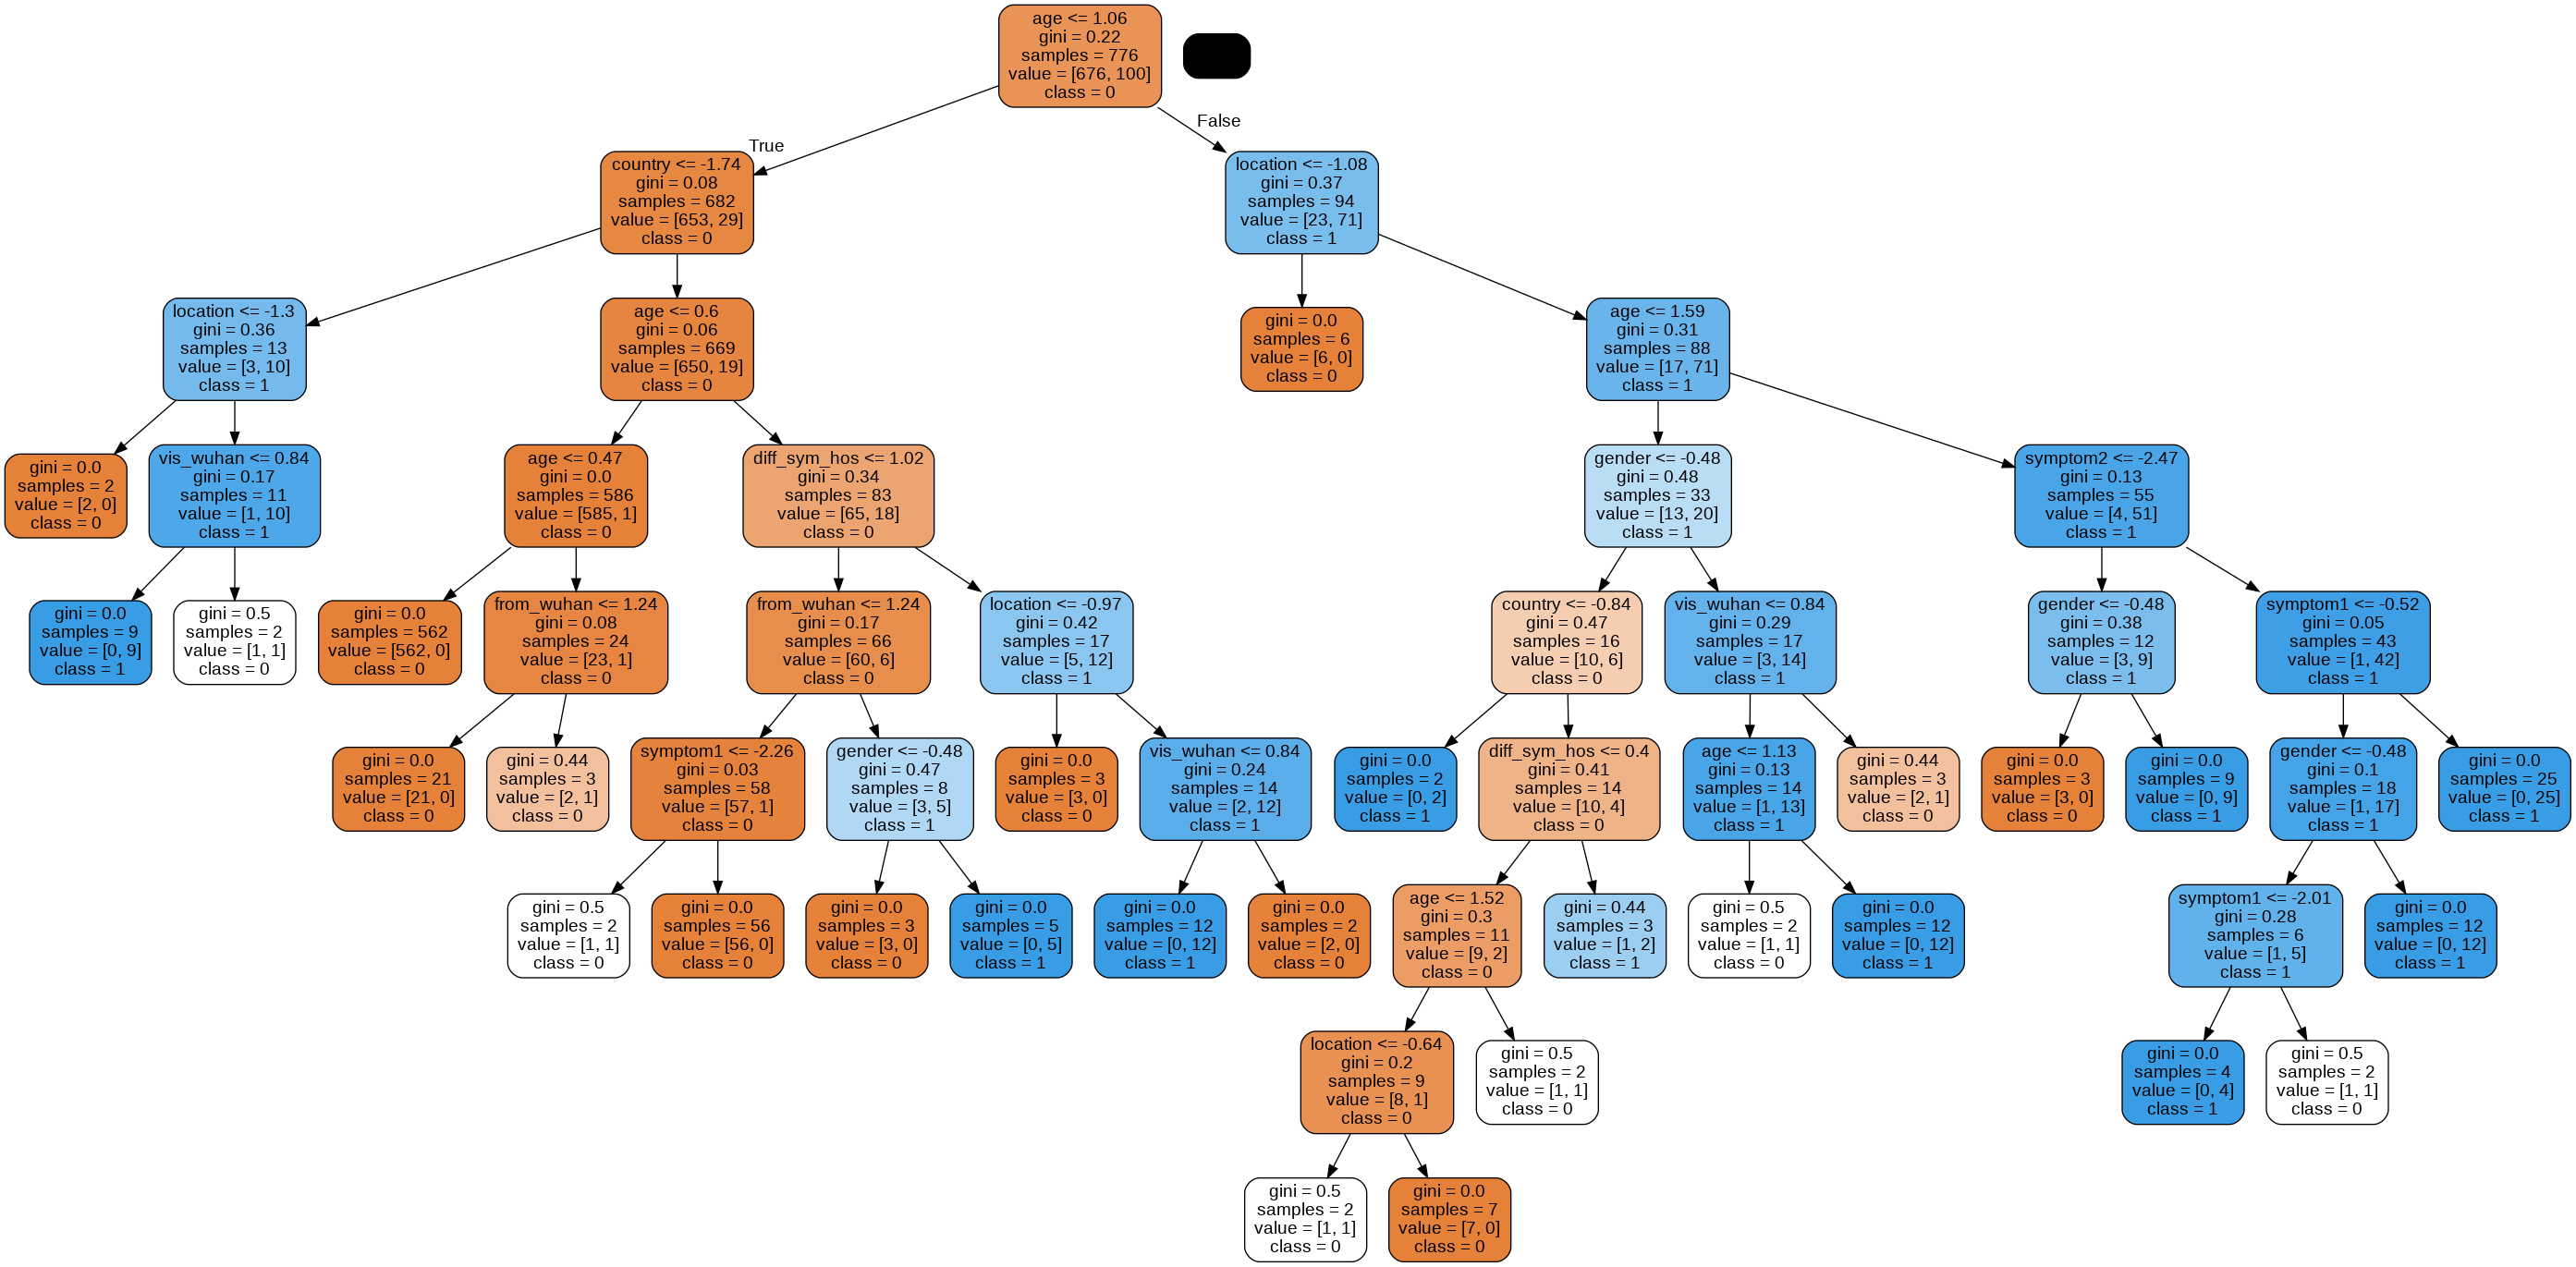

In [ ]:
#Visualizing the Decision Tree
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
feature_cols = X.columns
export_graphviz(D_Tree, out_file= dot_data, feature_names = feature_cols, class_names = ["0", "1"], rounded = True, proportion = False, precision = 2, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("Decision Tree.png")
Image(graph.create_png())

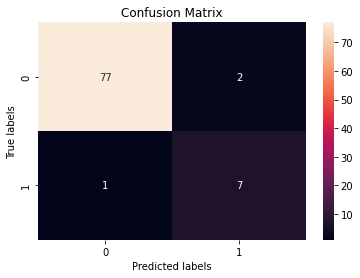

In [ ]:
#Calculating Prediction
yPred = D_Tree.predict(xTest)

#----------------------------------------------------
#Calculating Confusion Matrix
CM = confusion_matrix(yTest, yPred)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(yTest, yPred)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        79
           1       0.78      0.88      0.82         8

    accuracy                           0.97        87
   macro avg       0.88      0.92      0.90        87
weighted avg       0.97      0.97      0.97        87



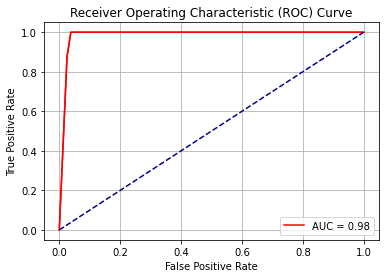

In [ ]:
#Calculating Area Under the Curve with predict probapility:
fpr, tpr, thresholds = roc_curve(yTest, D_Tree.predict_proba(xTest)[:,1])

roc_auc = roc_auc_score(yTest, D_Tree.predict_proba(xTest)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='red', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.grid()